In [1]:
import os
import sys
sys.path.append('../../../hetnet-ml/src')

import time
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import logit

import graph_tools as gt
from extractor import MatrixFormattedGraph
import plot_tools as pt

DATA_DIR = '../../data'

In [2]:
from scipy import interp                                                             
from sklearn.metrics import precision_recall_curve, roc_curve, auc        

In [3]:
coefs = []
preds = {}

# set the parameters to get the right load directory
base_dir = os.path.join(DATA_DIR, 'time_networks-6_metanode')
max_indication_network_diff = 0
alpha = 0.1
scoring = 'recall'
negative_multiplier = 10
min_pmids = 2
gs_treat = False
w = 0.6
seed = 0

# Build the proper load Directory
test_params = os.path.join('alpha_{}'.format(alpha), 
                           '{}x_pos-neg'.format(negative_multiplier), 
                           '{}_year_diff'.format(max_indication_network_diff))
if scoring != 'roc_auc':
    test_params = os.path.join(test_params, '{}-scoring'.format(scoring))
if min_pmids > 1:
    test_params = os.path.join(test_params, '{}_pmids'.format(min_pmids))
if gs_treat:                                                                                                            
    test_params = os.path.join(test_params, 'gs_treats')
if w != 0.4:
    test_params = os.path.join(test_params, 'dwpc_w_{}'.format(w))
if seed != 0:
    test_params = os.path.join(test_params, 'seed_{}'.format(seed))

# Read in the data
for year in range(1950, 2020, 5):
    out_dir = os.path.join(base_dir, str(year), test_params)
    
    # get the predictions for the year
    preds[year] = pd.read_csv(os.path.join(out_dir, 'predictions.csv'))

    # Read the model coefficients
    coef = pd.read_csv(os.path.join(out_dir, 'model_coefficients.csv'))

    # Only keep the actual model coefficients (rather than standardized...)
    coef = coef.set_index('feature').rename(columns={'coef': year})[year]
    coefs.append(coef)    
    
coefs = pd.concat(coefs, axis=1, sort=False).reset_index().rename(columns={'index': 'feature'})

In [4]:
coefs.head()

,feature,1950,1955,1960,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015
0,intercept,-3.577177,-3.02622,-2.823134,-2.824990,-2.870329,-2.959200,-2.978062,-3.074820,-3.087582,-3.105759,-3.113796,-3.147426,-3.013563,-3.042339
1,degree_CDafA,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.042249,0.041610,0.000000,0.009561,0.000000,0.039214,0.003981,0.016821
2,degree_CDafPH,-0.185517,0.00000,0.000000,0.002762,0.029087,0.018687,0.002304,0.033843,0.090246,0.111287,0.159012,0.171069,0.158160,0.193575
3,degree_CDagPS,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055291,0.012581,0.000000,0.000000,0.000000,0.000000,0.000000
4,degree_CDawPS,0.041134,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034349,0.039538,0.003719,0.018874,0.000000,0.024059,0.039269


In [5]:
years = [i for i in range(1950, 2020, 5)]

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


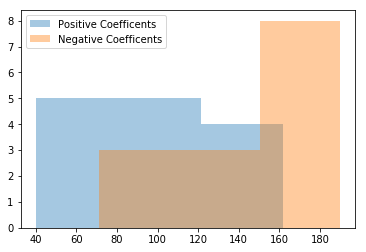

In [6]:
sns.distplot((coefs[years] > 0).sum(), kde=False, label='Positive Coefficents')
sns.distplot((coefs[years] < 0).sum(), kde=False, label='Negative Coefficents')
plt.legend();

#### Do some processing on the coefficitents

In [7]:
coefs = coefs.replace(0.0, np.nan)

# Count how many are selected each year
coefs['counts'] = coefs[years].T.count()

# How many positive?
coefs['n_pos'] = (coefs[years].T > 0).sum()

# Negative?
coefs['n_neg'] = (coefs[years].T < 0).sum()

# Mean for a coef over all years?
coefs['mean_val'] = coefs[years].T.mean()

# Median?
coefs['median_val'] = coefs[years].T.median()

# STD? 
coefs['std'] = coefs[years].T.std()

# Standarized mean?
coefs['mean_std'] = coefs['mean_val'] / coefs['std']

remainder = [c for c in coefs.columns if c not in years]

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [8]:
melt_coef = coefs.melt(id_vars=remainder, value_vars=years)
melt_coef.head()

,feature,counts,n_pos,n_neg,mean_val,median_val,std,mean_std,variable,value
0,intercept,14,0,14,-3.046028,-3.034279,0.185253,-16.442504,1950,-3.577177
1,degree_CDafA,6,6,0,0.025573,0.028018,0.017439,1.466423,1950,NaN
2,degree_CDafPH,12,11,1,0.065376,0.062044,0.105764,0.618134,1950,-0.185517
3,degree_CDagPS,2,2,0,0.033936,0.033936,0.030201,1.123678,1950,NaN
4,degree_CDawPS,7,7,0,0.028706,0.034349,0.013891,2.066475,1950,0.041134


In [9]:
test_mps = (coefs.query('n_pos >= 5 and mean_std > .7 and mean_val > .1')
                 .sort_values('mean_val', ascending=False)['feature'][:5].values)

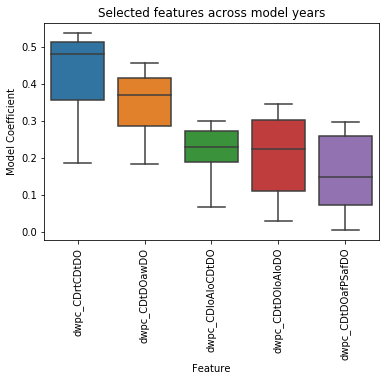

In [10]:
sns.boxplot(x='feature', y='value', data=melt_coef.query('feature in @test_mps').sort_values('mean_val', ascending=False))
plt.xlabel('Feature')
plt.ylabel('Model Coefficient')
plt.title('Selected features across model years')
plt.xticks(rotation=90);

### See if we can standardize the coefficients across model years.... 

Becasue the min and max coefficient in each model may be different values, 
Standardizing each year by min and max will show how much these really differ between years

In [11]:
year_max_coef = melt_coef.groupby('variable')['value'].max()
year_max_coef[1950]

0.3057526694135879

In [12]:
melt_coef['rel_value'] = melt_coef.apply(lambda row: row['value'] / year_max_coef[row['variable']], axis=1)

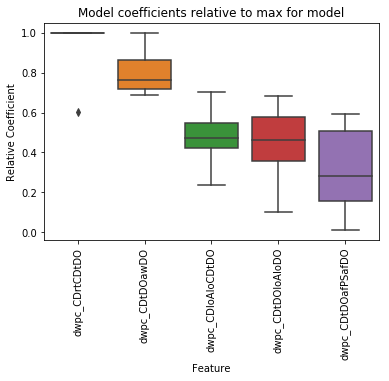

In [13]:
sns.boxplot(x='feature', y='rel_value', data=melt_coef.query('feature in @test_mps').sort_values('mean_val', ascending=False))
plt.xlabel('Feature')
plt.ylabel('Relative Coefficient')
plt.title('Model coefficients relative to max for model')
plt.xticks(rotation=90);

In [14]:
top_rels = melt_coef.fillna(0).groupby('feature')['rel_value'].mean().sort_values(ascending=False).index[:10]

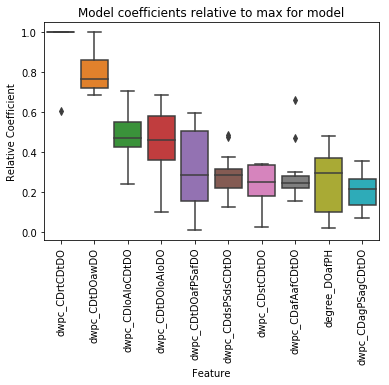

In [15]:
sns.boxplot(x='feature', y='rel_value', data=melt_coef.query('feature in @top_rels').sort_values('mean_val', ascending=False))
plt.xlabel('Feature')
plt.ylabel('Relative Coefficient')
plt.title('Model coefficients relative to max for model')
plt.xticks(rotation=90);

In [16]:
coef_info = pd.melt(coefs.fillna(0.0), id_vars=['feature'], value_vars=years)
coef_info = coef_info.rename(columns={'variable': 'network_year'})
coef_info.head(2)

,feature,network_year,value
0,intercept,1950,-3.577177
1,degree_CDafA,1950,0.000000


In [17]:
coef_counts = []
for year, df in coef_info.groupby('network_year'):
    n_pos = (df['value'] > 0).sum()
    n_neg = (df['value'] < 0).sum()
    coef_counts.append(pd.DataFrame({'network_year': [year]*2, 'num': [n_pos, n_neg], 
                                     'Coefficient Sign': ['Postivie', 'Negative']}))
coef_counts = pd.concat(coef_counts)

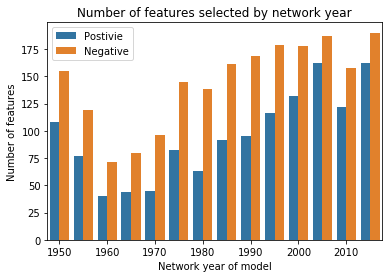

In [18]:
name_map = {}
sns.barplot(x='network_year', y='num', data=coef_counts, hue='Coefficient Sign')

plt.title('Number of features selected by network year')
plt.xlabel('Network year of model')
plt.ylabel('Number of features')
plt.legend(title='')

tick_delta = 2
locs, labels = plt.xticks(rotation=0)
plt.xticks(locs[::tick_delta], labels[::tick_delta]);

## ROC Results

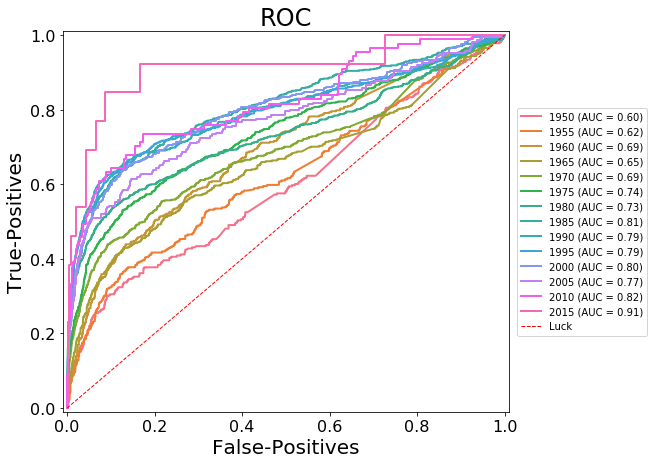

In [19]:
ys = []
y_preds = []

with sns.color_palette('husl', n_colors=len(preds)):
    for year in range(1950, 2020, 5):
        y_true = preds[year].dropna(subset=['test_probas'])['status']
        y_pred = preds[year].dropna(subset=['test_probas'])['test_probas']
        ys.append(y_true)
        y_preds.append(y_pred)
        pt.graph_single_roc(y_true, y_pred, label=str(year), lw=2)
    #pt.graph_mean_roc(ys, y_preds)
    pt.graph_roc_boilerplate('ROC')
    plt.legend(loc='right', bbox_to_anchor=(1.32,.5));

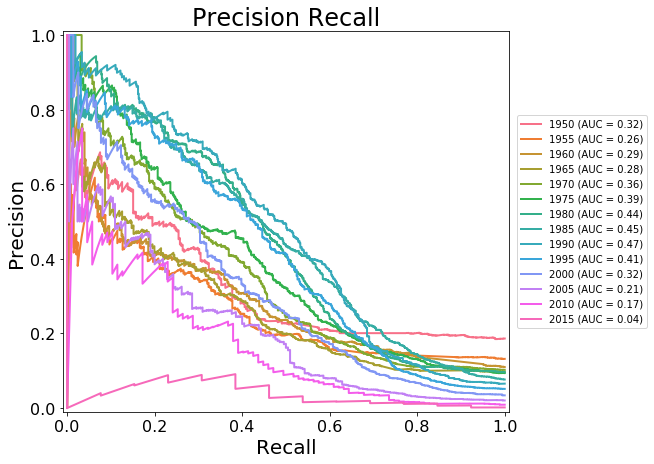

In [20]:
ys = []
y_preds = []

with sns.color_palette('husl', n_colors=len(preds)):


    for year in range(1950, 2020, 5):
        y_true = preds[year].dropna(subset=['test_probas'])['status']
        y_pred = preds[year].dropna(subset=['test_probas'])['test_probas']

        ys.append(y_true)
        y_preds.append(y_pred)

        pt.graph_single_prc(y_true, y_pred, label=str(year), lw=2)
    #pt.graph_mean_prc(ys, y_preds)
    pt.graph_prc_boilerplate('Precision Recall')
    plt.legend(loc='right', bbox_to_anchor=(1.32,.5));

In [21]:
from scipy import interp                                                             
from sklearn.metrics import precision_recall_curve, roc_curve, auc        

def calc_roc(df):
    fpr, tpr, thresholds = roc_curve(df['status'], df['all_probas'])                                  
    roc_auc = auc(fpr, tpr)                                                      
    return roc_auc
    
def calc_prc(df):
    pre, rec, thresholds = precision_recall_curve(df['status'], df['all_probas'])                                  
    roc_prc = auc(rec, pre)                                                      
    return roc_prc

In [22]:
from collections import defaultdict

In [23]:
roc_result = defaultdict(list)

for year in range(1950, 2020, 5):
    frame = preds[year].query('dataset == "test"')
    
    # Calc ROC and PRC
    roc = calc_roc(frame)
    prc = calc_prc(frame)
    
    # Add ROC to data frame
    roc_result['network_year'].append(year)
    roc_result['metric'].append(roc)
    roc_result['metric_name'].append('AUROC')
    
    # Add PRC to data frame
    roc_result['network_year'].append(year)
    roc_result['metric'].append(prc)
    roc_result['metric_name'].append('AUPRC')


roc_result = pd.DataFrame(roc_result).sort_values(['metric_name', 'network_year'])
roc_result

,metric,metric_name,network_year
1,0.320770,AUPRC,1950
3,0.257315,AUPRC,1955
5,0.285125,AUPRC,1960
7,0.277569,AUPRC,1965
9,0.355479,AUPRC,1970
11,0.385492,AUPRC,1975
13,0.440363,AUPRC,1980
15,0.445235,AUPRC,1985
17,0.472283,AUPRC,1990
19,0.414873,AUPRC,1995


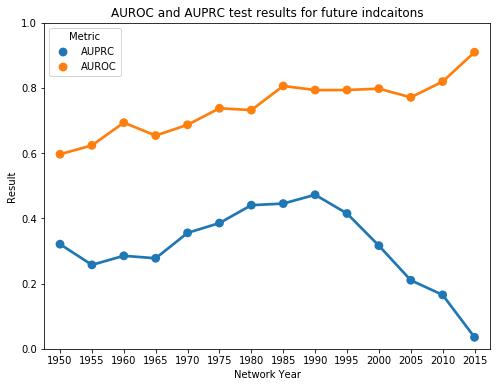

In [24]:
plt.figure(figsize=(8,6))
sns.pointplot(x='network_year', y='metric', hue='metric_name', data=roc_result)

plt.title('AUROC and AUPRC test results for future indcaitons')
plt.xlabel('Network Year')
plt.ylabel('Result')
plt.ylim([0, 1])
plt.legend(title='Metric', loc=2);

In [25]:
year_training_info = []
for year in range(1950, 2020, 5):

    test_true = preds[year].dropna(subset=['test_probas'])['status'].sum()
    all_true = preds[year]['status'].sum()
    train_true = all_true - test_true

    year_training_info.append({'train_true': train_true,
                               'test_true': test_true, 
                               'all_true': all_true,
                               'year': year})
train_info = pd.DataFrame(year_training_info)

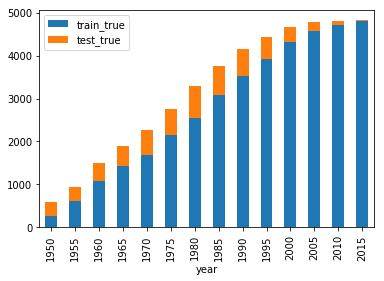

In [26]:
train_info.set_index('year')[['train_true', 'test_true']].plot(kind='bar', stacked=True);